In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

In [54]:
def unit_signal(t):
    return 1.0 if t >= 0 else 0.0

unit_signal_vectorize = np.vectorize(unit_signal)

In [55]:
def ramp_signal(t):
    return t * unit_signal(t)

ramp_signal_vectorize = np.vectorize(ramp_signal)

In [56]:
def rect_signal(t):
    return 1.0 if (t <= 0.5) & (t >= -0.5) else 0.0

rect_signal_vectorize = np.vectorize(rect_signal)

In [57]:
def delta_signal(t):
    return 1.0 if t == 0 else 0.0

delta_signal_vectorize = np.vectorize(delta_signal)

## Problem 1
Evaluate the convolution of the following signals
1. $ \textrm{rect} \left( \frac{t-a}{a} \right) * \delta (t-b)$

2. $\textrm{rect} \left( \frac{t}{a} \right) * \textrm{rect} \left( \frac{t}{a} \right) $

3. $ t[u(t)-u(t-1)]*u(t) $

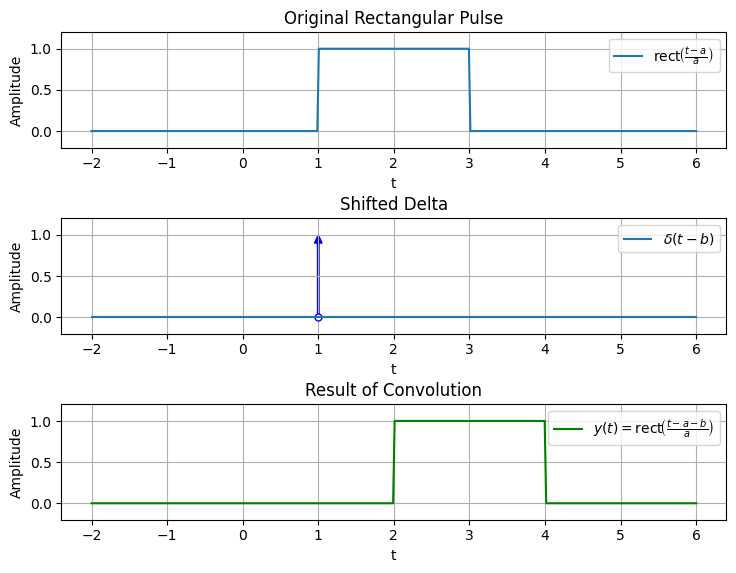

In [47]:
# Problem 1.1.

import numpy as np
import matplotlib.pyplot as plt

# Parameters
a = 2.0
b = 1.0
t = np.linspace(-2, 6, 400)

# Define signals
rect_signal = rect_signal_vectorize((t - a) / a)
delta_signal = delta_signal_vectorize(t - b)

# Convolution result:
y = rect_signal_vectorize((t - a - b) / a)

# Plot
fig, axs = plt.subplots(3, 1, figsize=(8, 6))
plt.tight_layout(pad=3)

axs[0].plot(t, rect_signal, label=r"$\mathrm{rect}\!\left(\frac{t - a}{a}\right)$")
axs[0].set_title("Original Rectangular Pulse")
axs[0].legend(loc="upper right")
axs[0].grid(True)

axs[1].arrow(b, 0, 0, 1, head_width=0.1, head_length=0.1, width=0.02, fc="blue", ec="blue", length_includes_head=True)
axs[1].plot(b, 0, color="blue", marker = "o", markerfacecolor="white", markersize=5)
axs[1].plot(t, delta_signal, label=r"$\delta(t - b)$")
axs[1].set_title("Shifted Delta")
axs[1].legend(loc="upper right")
axs[1].grid(True)


axs[2].plot(t, y, "g", label=r"$y(t) = \mathrm{rect}\!\left(\frac{t - a - b}{a}\right)$")
axs[2].set_title("Result of Convolution")
axs[2].legend(loc="upper right")
axs[2].grid(True)

for ax in axs:
    ax.set_xlabel("t")
    ax.set_ylabel("Amplitude")
    ax.set_ylim(-0.2, 1.2)

plt.savefig("../images/problem_1_1.png", dpi=300, bbox_inches="tight")

plt.show()


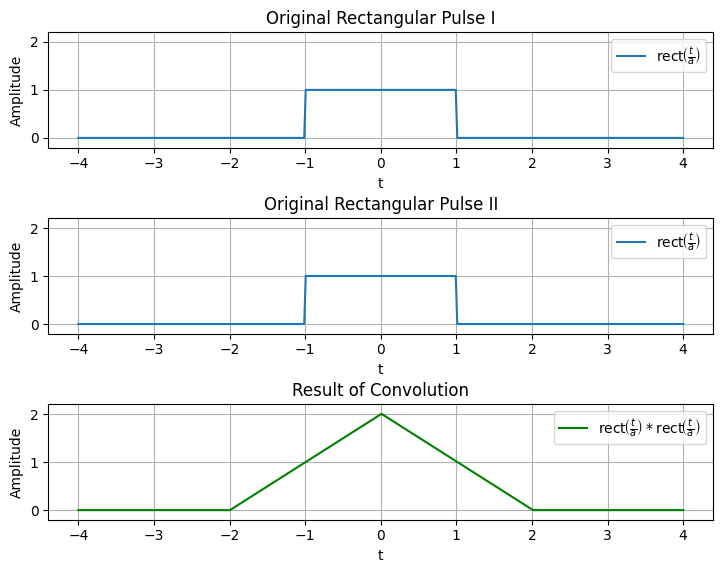

In [59]:
# Problem 1.2.

import numpy as np
import matplotlib.pyplot as plt

# Parameters
a = 2.0
t = np.linspace(-4, 4, 400)

# Define signals
rect_signal = rect_signal_vectorize(t / a)

# Convolution result:
y = np.convolve(rect_signal, rect_signal, mode="same") * (t[1] - t[0])

# Plot
fig, axs = plt.subplots(3, 1, figsize=(8, 6))
plt.tight_layout(pad=3)

axs[0].plot(t, rect_signal, label=r"$\mathrm{rect}\!\left(\frac{t}{a}\right)$")
axs[0].set_title("Original Rectangular Pulse I")
axs[0].legend(loc="upper right")
axs[0].grid(True)

axs[1].plot(t, rect_signal, label=r"$\mathrm{rect}\!\left(\frac{t}{a}\right)$")
axs[1].set_title("Original Rectangular Pulse II")
axs[1].legend(loc="upper right")
axs[1].grid(True)

axs[2].plot(t, y, "g", label=r"$\mathrm{rect}\!\left(\frac{t}{a}\right) * \mathrm{rect}\!\left(\frac{t}{a}\right)$")
axs[2].set_title("Result of Convolution")
axs[2].legend(loc="upper right")
axs[2].grid(True)

for ax in axs:
    ax.set_xlabel("t")
    ax.set_ylabel("Amplitude")
    ax.set_ylim(-0.2, 2.2)

plt.savefig("../images/problem_1_2.png", dpi=300, bbox_inches="tight")

plt.show()

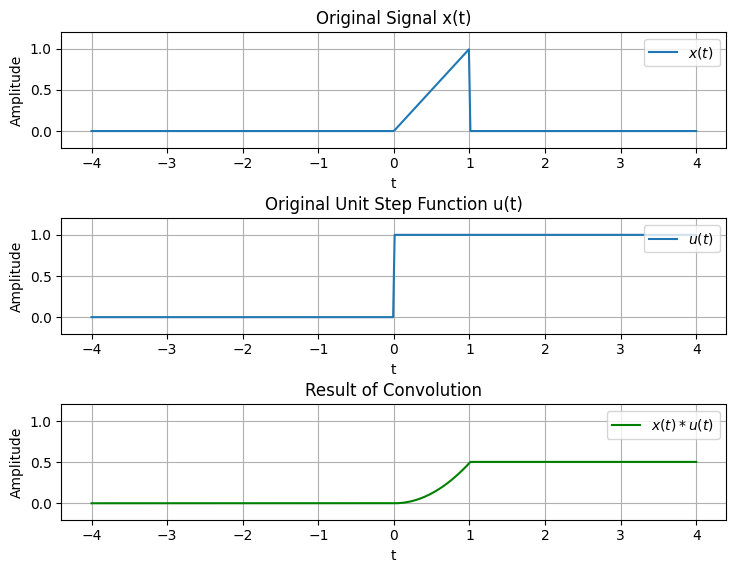

In [61]:
# Problem 1.3.

import numpy as np
import matplotlib.pyplot as plt

# Parameters
a = 2.0
t = np.linspace(-4, 4, 400)

# Define signals
x = t * (unit_signal_vectorize(t) - unit_signal_vectorize(t - 1))
u = unit_signal_vectorize(t)

# Convolution result:
y = np.convolve(x, u, mode="same") * (t[1] - t[0])

# Plot
fig, axs = plt.subplots(3, 1, figsize=(8, 6))
plt.tight_layout(pad=3)

axs[0].plot(t, x, label=r"$x(t)$")
axs[0].set_title("Original Signal x(t)")
axs[0].legend(loc="upper right")
axs[0].grid(True)

axs[1].plot(t, u, label=r"$u(t)$")
axs[1].set_title("Original Unit Step Function u(t)")
axs[1].legend(loc="upper right")
axs[1].grid(True)

axs[2].plot(t, y, "g", label=r"$x(t) * u(t)$")
axs[2].set_title("Result of Convolution")
axs[2].legend(loc="upper right")
axs[2].grid(True)

for ax in axs:
    ax.set_xlabel("t")
    ax.set_ylabel("Amplitude")
    ax.set_ylim(-0.2, 1.2)

plt.savefig("../images/problem_1_3.png", dpi=300, bbox_inches="tight")

plt.show()

## Problem 2
Determine the convolution $y(t) = h(t)*x(t)$ using Graphical Interpretation of the pairs of the signals shown

1. <a href="https://imgbb.com/"><img src="https://i.ibb.co/YDVdjT1/ii-1.jpg" alt="ii-1" border="0"></a>

2. <a href="https://imgbb.com/"><img src="https://i.ibb.co/102mFqd/ii-2.jpg" alt="ii-2" border="0"></a>


3. <a href="https://imgbb.com/"><img src="https://i.ibb.co/vDsDW2z/ii-3.jpg" alt="ii-3" border="0"></a>
---

## [optional]
4. <a href="https://imgbb.com/"><img src="https://i.ibb.co/fdND0Dv/ii-4.jpg" alt="ii-4" border="0"></a>



## Problem 3
Let $f(t)$ and $g(t)$ be given as follows:

---

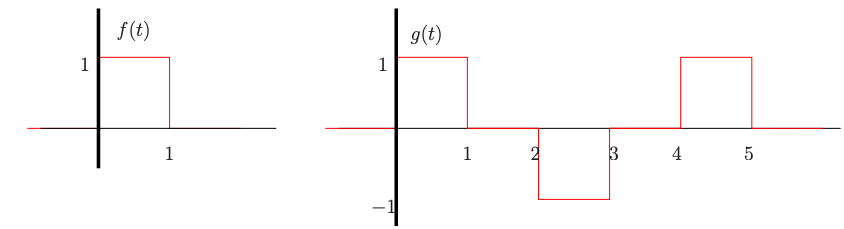

1. sketch the function : $x(t)$ = $f(t)*g(t)$
2. show that if $a(t) = b(t)*c(t)$,then $(Mb(t))*c(t) = Ma(t)$, for any real number M (hint: use the convolution integral formula)


## Problem 4
Find the convolution $y[n] = h[n]*x[n]$ of the following signals:

1.
$x[n] = \begin{cases} -1 , -5 \leq n \leq -1 \\ 1 , 0 \leq n \leq 4 \end{cases} h[n]=2u[n]$

2.
$x[n] = u[n],\, h[n] = 1 \; ; 0 \leq n \leq 9 $


3.
$x[n] = \left( \frac{1}{2} \right)^n u[n],\, h[n] = \delta[n] +\delta[n-1] +  \left( \frac{1}{3} \right)^n u[n]$

4.
$x[n] = \left( \frac{1}{3} \right)^n u[n],\, h[n] = \delta[n] + \left( \frac{1}{2} \right)^n u[n]$



## Problem 5
Find the convolution $y[n] = h[n]*x[n]$ of the following signals
1.
$x[n] = \left\{ 1,-\frac{1}{2},\frac{1}{4},-\frac{1}{8} ,\frac{1}{16} \right \},\, h[n]=\left\{ 1,-1,1,-1 \right\}$

1.
$x[n] = \left\{ 1,2,3,0,-1, \right \},\, h[n]=\left\{ 2,-1,3,1,-2 \right\}$

1.
$x[n] = \left\{ 3,\frac{1}{2},-\frac{1}{4},1,4 \right \},\, h[n]=\left\{ 2,-1,\frac{1}{2}, -\frac{1}{2} \right\}$

1.
$x[n] = \left\{ -1,\frac{1}{2},\frac{3}{4},-\frac{1}{5},1 \right \},\, h[n]=\left\{ 1,1,1,1,1 \right\}$



## Problem 6





### Problem 6.1 : Convolution - 1D
The following code creates a gaussian pulse and its self convolutions. Study and apply the convolution between signal e and another signal e with noise (e_noise) and write the report to analyze the results.

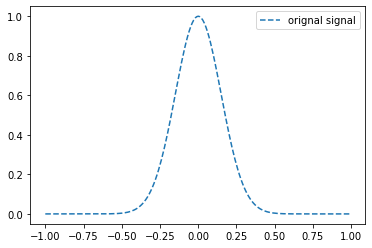

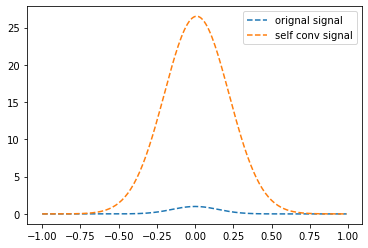

In [ ]:
t = np.linspace(-1, 1, 2 * 100, endpoint=False)
i, q, e = signal.gausspulse(t, fc=5, retquad=True, retenv=True)
plt.plot(t, e, '--',label = 'orignal signal')
plt.legend(loc='upper right')
plt.show()


conv_e = np.convolve(e,e,'same')
plt.plot(t, e, '--',label = 'orignal signal')
plt.plot(t, conv_e, '--',label = 'self conv signal')
plt.legend(loc='upper right')
plt.show()

e_noise = e + np.random.randn(len(e))*2.5
conv_e_noise = np.convolve(e,e_noise,'same')

# TODO : Apply the convolution between signal e and another signal e with noise (e_noise) and check the results




### Problem 6.2

From the self convolution below, when increasing the number of self convolution (now is 8), what is noticeable from the final shape resulted from the convolution?

(HINT 01: Central limit theorem)

(HINT 02: What is Probability Density Function (PDF) of $z$ if $z=x+y$ $?$ )

In [ ]:
from scipy.stats import uniform

x = np.linspace(-5,5, 1000)
plt.plot(x, uniform.pdf(x),
       'r-', lw=5, alpha=0.6, label='uniform pdf')

plt.show()


x = np.linspace(-15,15, 10000)
pdf_1 = uniform.pdf(x)
pdf_2 = uniform.pdf(x)

for i in range(8):
    pdf_2 = np.convolve(pdf_2,pdf_1, 'same')

pdf_2 = pdf_2/np.max(pdf_2)
plt.plot(x, pdf_2,'r-', lw=5, alpha=0.6, label='conv uniform')

## Problem 7
### 2D (image) signal convolution:
The following code show the 2D signal (image f(x,y)) and a kernel (diag_line). Study the convolution of the kernel and the image. Apply with "circuits.png" image and analyze the results.



## TODO : Apply diag_line to the "circuits.png image" and analyse the results

In [ ]:
!wget https://drive.google.com/uc?id=1hQ8uKocLTjaKmrJm-O4BfZxvLLM1Cfa- -O circuits.png
!wget https://drive.google.com/uc?id=1WoISJ6-FECt-gt6Ovjlfmz89oGH812GM -O hamtaro0.jpg

In [ ]:
image_path = 'hamtaro0.jpg'

diag_line = np.array([[ 2, -1, -1],
                    [-1, 2, -1],
                    [-1, -1, 2]])

ham = cv2.imread(image_path,0)
plt.figure(figsize=(10,10))
plt.imshow(ham, cmap='gray')
plt.show()
grad = signal.convolve2d(ham,diag_line,boundary='symm',mode='same')
plt.figure(figsize=(10,10))
plt.imshow(grad, cmap='gray')
plt.show()

# TODO : Apply diag_line to the "circuits.png image" and analyse the results




## Problem 8
Are the following systems linear or time invariant?
1. $x(t)$ -> **System(a)** -> $7x(t-1)$
1. $x(t)$ -> **System(b)** -> $cos(2x(t))$
1. $x(t)$ -> **System(c)** -> $t$
1. $x(t)$ -> **System(d)** -> $x(t)+t$